In [8]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import svd
import pandas as pd

class CA(object):
    """Simple corresondence analysis.
    
    Inputs
    ------
    ct : array_like
      Two-way contingency table. If `ct` is a pandas DataFrame object,
      the index and column values are used for plotting.
    Notes
    -----
    The implementation follows that presented in 'Correspondence
    Analysis in R, with Two- and Three-dimensional Graphics: The ca
    Package,' Journal of Statistical Software, May 2007, Volume 20,
    Issue 3.
    """

    def __init__(self, ct):
        self.rows = ct.index.values if hasattr(ct, 'index') else None
        self.cols = ct.columns.values if hasattr(ct, 'columns') else None
        
        # contingency table
        N = np.matrix(ct, dtype=float)

        # correspondence matrix from contingency table
        P = N / N.sum()

        # row and column marginal totals of P as vectors
        r = P.sum(axis=1)
        c = P.sum(axis=0).T

        # diagonal matrices of row/column sums
        D_r_rsq = np.diag(1. / np.sqrt(r.A1))
        D_c_rsq = np.diag(1. / np.sqrt(c.A1))

        # the matrix of standarized residuals
        S = D_r_rsq * (P - r * c.T) * D_c_rsq

        # compute the SVD
        U, D_a, V = svd(S, full_matrices=False)
        D_a = np.asmatrix(np.diag(D_a))
        V = V.T

        # principal coordinates of rows
        F = D_r_rsq * U * D_a

        # principal coordinates of columns
        G = D_c_rsq * V * D_a

        # standard coordinates of rows
        X = D_r_rsq * U

        # standard coordinates of columns
        Y = D_c_rsq * V

        # the total variance of the data matrix
        inertia = sum([(P[i,j] - r[i,0] * c[j,0])**2 / (r[i,0] * c[j,0])
                       for i in range(N.shape[0])
                       for j in range(N.shape[1])])

        self.F = F.A
        self.G = G.A
        self.X = X.A
        self.Y = Y.A
        self.inertia = inertia
        self.eigenvals = np.diag(D_a)**2

    def plot(self):
        """Plot the first and second dimensions."""
        xmin, xmax = None, None
        ymin, ymax = None, None
        if self.rows is not None:
            for i, t in enumerate(self.rows):
                x, y = self.F[i,0], self.F[i,1]
                plt.text(x, y, t, va='center', ha='center', color='r')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.F[:, 0], self.F[:, 1], 'ro')

        if self.cols is not None:
            for i, t in enumerate(self.cols):
                x, y = self.G[i,0], self.G[i,1]
                plt.text(x, y, t, va='center', ha='center', color='b')
                xmin = min(x, xmin if xmin else x)
                xmax = max(x, xmax if xmax else x)
                ymin = min(y, ymin if ymin else y)
                ymax = max(y, ymax if ymax else y)
        else:
            plt.plot(self.G[:, 0], self.G[:, 1], 'bs')

        if xmin and xmax:
            pad = (xmax - xmin) * 0.1
            plt.xlim(xmin - pad, xmax + pad)
        if ymin and ymax:
            pad = (ymax - ymin) * 0.1
            plt.ylim(ymin - pad, ymax + pad)

        plt.grid()
        plt.xlabel('Dim 1')
        plt.ylabel('Dim 2')

    def scree_diagram(self, perc=True, *args, **kwargs):
        """Plot the scree diagram."""
        eigenvals = self.eigenvals
        xs = np.arange(1, eigenvals.size + 1, 1)
        ys = 100. * eigenvals / eigenvals.sum() if perc else eigenvals
        plt.plot(xs, ys, *args, **kwargs)
        plt.xlabel('Dimension')
        plt.ylabel('Eigenvalue' + (' [%]' if perc else ''))

In [22]:
teams = [
    ['Warriors' for _ in range(55)],
    ['Rockets' for _ in range(42)],
    ['Lakers' for _ in range(3)]
]
teams = [item for sublist in teams for item in sublist]
len(teams)
residences = [
    #Generate Warriors correlation
    ['SanFran' for _ in range(25)],
    ['SanDiego' for _ in range(10)],
    ['LosAngeles' for _ in range(10)],
    #Rockets and lakers Correlation
    ['SanFran' for _ in range(20)],
    ['SanDiego' for _ in range(15)],
    ['LosAngeles' for _ in range(20)],
    
    
]
residences = [item for sublist in residences for item in sublist]
len(residences)


nba = pd.DataFrame({
    'best':teams,
    'residence':residences
})
#for the contingency table:
nba['count'] = 1

(100, 3)


,best,residence,count
0,Warriors,SanFran,1
1,Warriors,SanFran,1
2,Warriors,SanFran,1
3,Warriors,SanFran,1
4,Warriors,SanFran,1


In [32]:
ct = pd.pivot_table(values='count' ,data=nba, index='residence', columns='best', aggfunc='sum', fill_value=0)
ct

best,Lakers,Rockets,Warriors
residence,,,
LosAngeles,3,17,10
SanDiego,0,15,10
SanFran,0,10,35


In [33]:
ca = CA(ct)
print(ca.eigenvals)
print(ca.inertia)

[1.87842077e-01 3.70015976e-02 1.15139313e-32]
0.22484367484367476


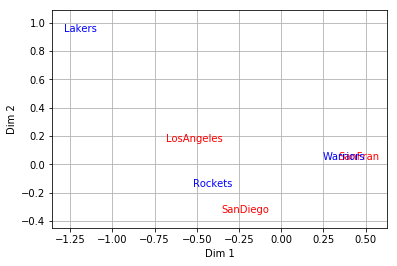

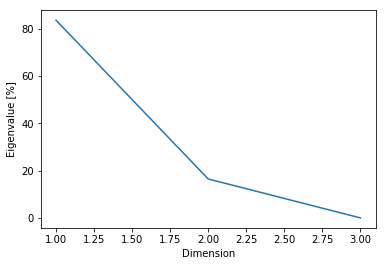

In [34]:
plt.figure(100)
ca.plot()

plt.figure(101)
ca.scree_diagram()

plt.show()